<a href="https://colab.research.google.com/github/olaysco/stroke-prediction-system/blob/main/stoke_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

results = {}

## Configuration & Helper Methods

In [3]:
# Load data sets
data=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset1.csv', encoding='ascii')
# Load data sets 2
data2=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset2.csv', encoding='ascii')
# Load data sets 3
data3=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset3.csv', encoding='ascii')
# Load data sets 4
data4=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset4.csv', encoding='ascii')

In [37]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name, model_name, results):
    """
    Trains and evaluates a given model, storing results in the results dictionary.

    Args:
        model: The machine learning model to train.
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target.
        y_test: Testing target.
        dataset_name: Name of the dataset (e.g., 'dataset_1').
        model_name: Name of the model (e.g., 'rfc').
        results: Dictionary to store the evaluation metrics.
    """
    print(f"Training {model_name} on {dataset_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else 'N/A'
    }

    print(f"Metrics for {model_name} on {dataset_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    if dataset_name not in results:
        results[dataset_name] = {}
    results[dataset_name][model_name] = {'test_metrics': metrics}

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} on {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Dataset 1 Preprocessing and Training


In [15]:
# show the first five rows of data sets
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [16]:
# names of the columns
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [17]:
# check tha data types of data sets
data.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64
smoking_status,object


In [18]:
# check the info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [19]:
# statistical summary of data set
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [20]:
# check the how many people have smooking status
data['age'].value_counts()

,count
age,
78.00,102
57.00,92
54.00,85
79.00,84
51.00,84
...,...
1.40,3
0.48,3
0.40,2


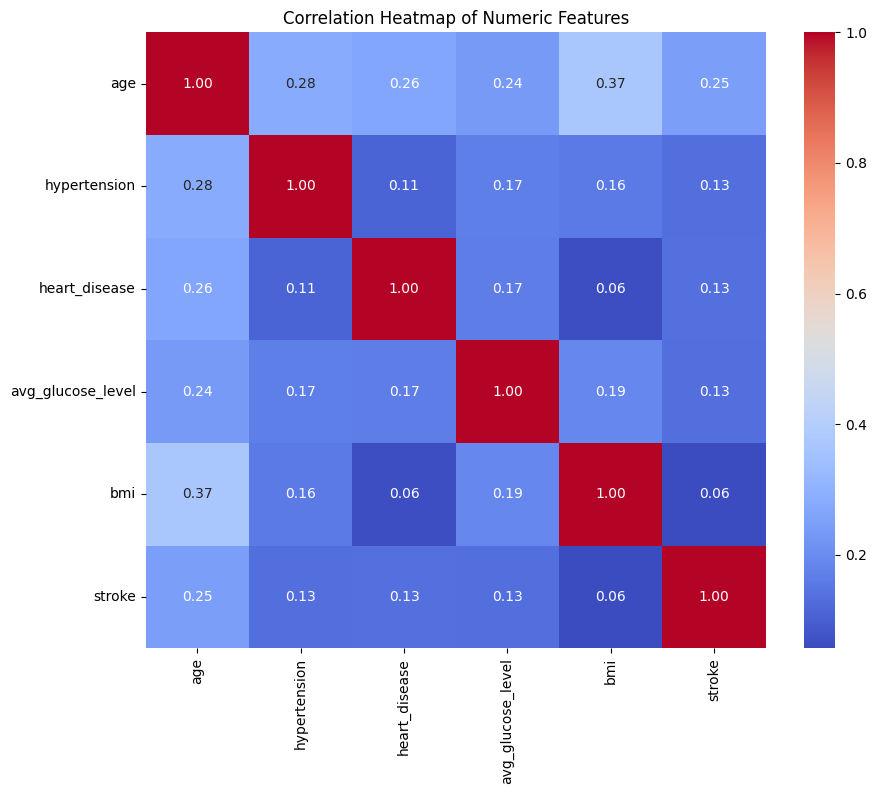

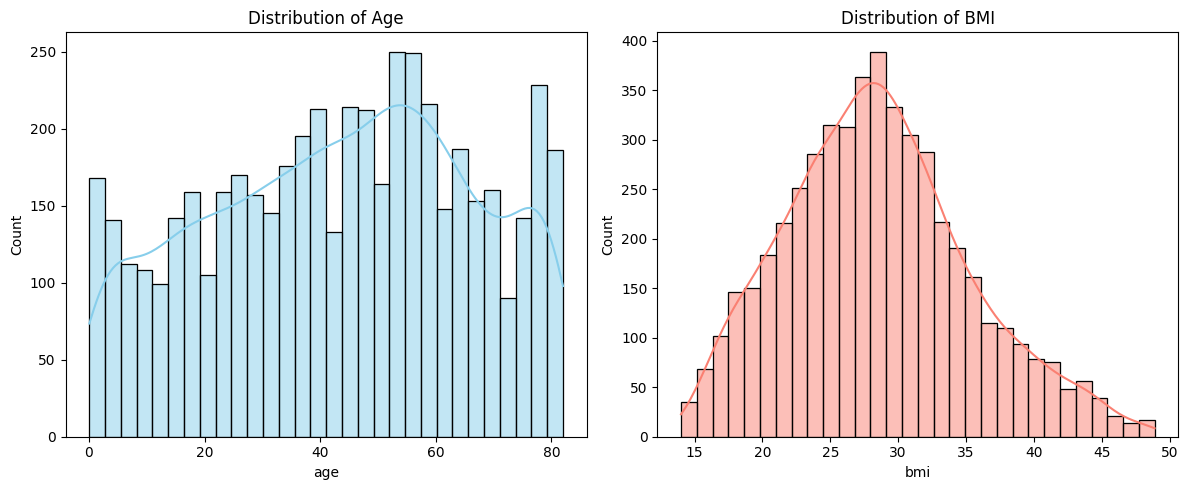

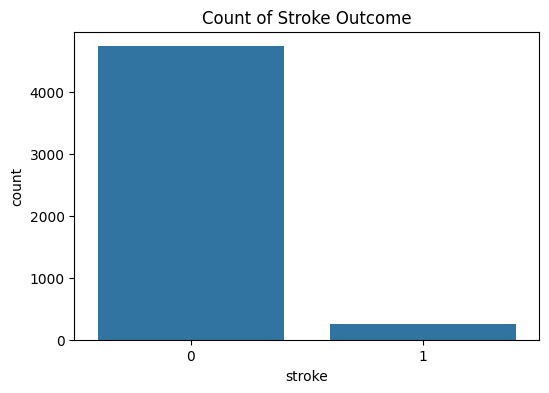

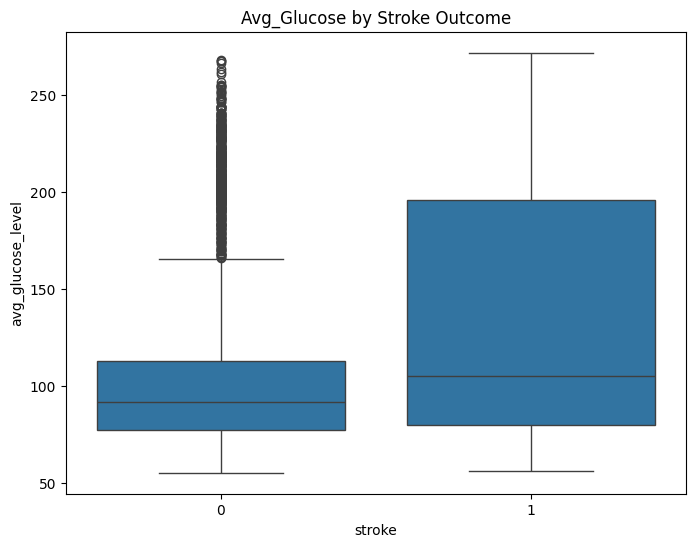

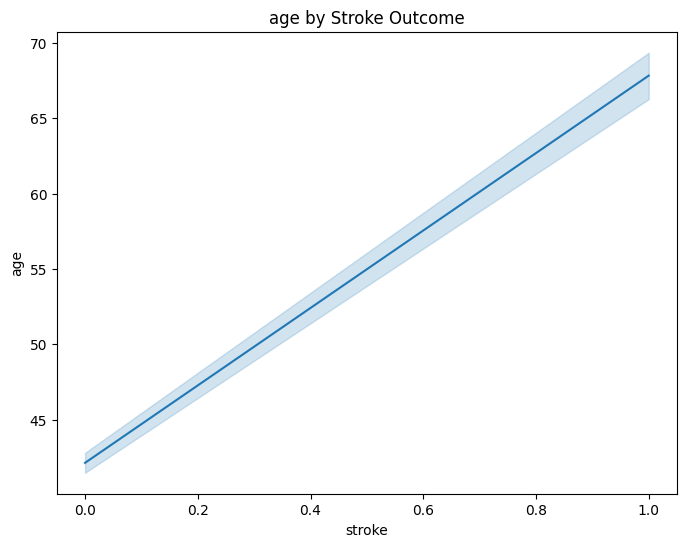

In [21]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data=data.select_dtypes(include=[np.number])
if numeric_data.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data['bmi'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=data)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=data)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()


# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='stroke', y='age', data=data)
plt.title('age by Stroke Outcome')
plt.show()

In [22]:
# change the Strig value to numeric
encoder=LabelEncoder()
data['gender']=encoder.fit_transform(data['gender'])
data['ever_married']=encoder.fit_transform(data['ever_married'])
data['work_type']=encoder.fit_transform(data['work_type'])
data['Residence_type']=encoder.fit_transform(data['Residence_type'])
data['smoking_status']=encoder.fit_transform(data['smoking_status'])

**Feature Engnieering**

In [23]:
# divide the data i features and traget columns
X=data.drop('stroke',axis=1)
y=data['stroke']

**Model Seletion**

In [24]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [28]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## RFC Model Training

Training RandomForestClassifier on dataset_1...
Metrics for RandomForestClassifier on dataset_1:
  accuracy: 0.7954
  precision: 0.1094
  recall: 0.3889
  f1: 0.1707
  roc_auc: 0.7478


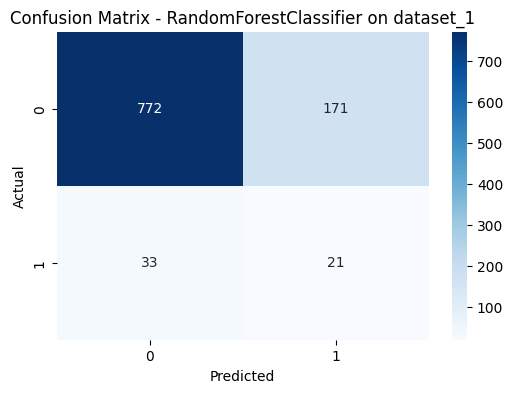

In [38]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=200,random_state=42, class_weight='balanced')
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_1', 'RandomForestClassifier', results)


## SVC Model Training

Training SVM on dataset_1...
Metrics for SVM on dataset_1:
  accuracy: 0.7412
  precision: 0.0952
  recall: 0.4444
  f1: 0.1569
  roc_auc: 0.7245


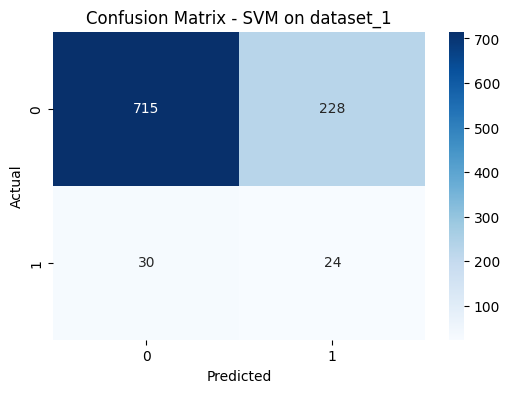

In [41]:
# train the SVM model
svm=SVC(kernel='rbf', probability=True) # Add probability=True for roc_auc
train_and_evaluate_model(svm, X_train, X_test, y_train, y_test, 'dataset_1', 'SVM', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_1...
Metrics for LogisticRegression on dataset_1:
  accuracy: 0.7372
  precision: 0.1438
  recall: 0.7778
  f1: 0.2428
  roc_auc: 0.8451


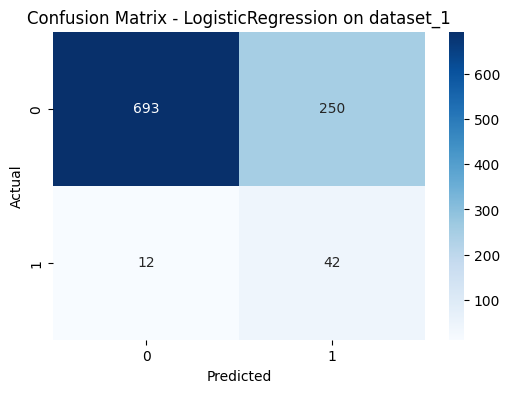

In [42]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_1', 'LogisticRegression', results)

# Dataset 2 Preprocessing and Training


In [ ]:
# show the first five rows of data sets
data2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# names of the columns
data2.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
# check tha data types of data sets
data2.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64
smoking_status,object


In [43]:
# check the info
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# statistical summary of data set
data2.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [44]:
# drop unused column
data2.drop('id',axis=1,inplace=True)

In [45]:
# check the how many people have smooking status
data2['age'].value_counts()

,count
age,
78.00,102
57.00,95
52.00,90
54.00,87
51.00,86
...,...
1.40,3
0.48,3
0.16,3


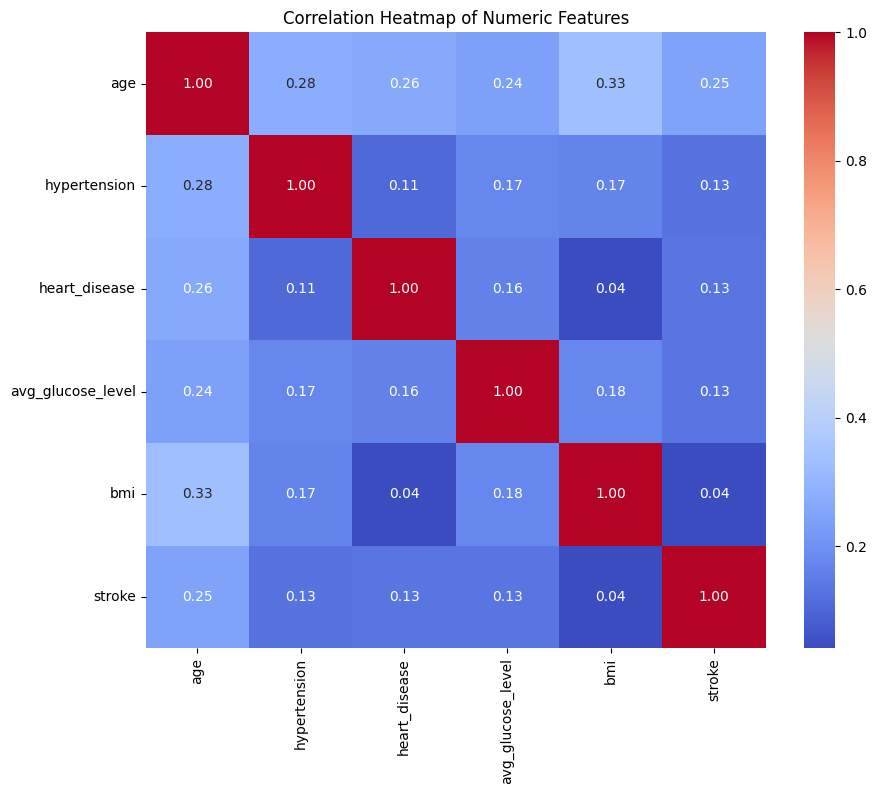

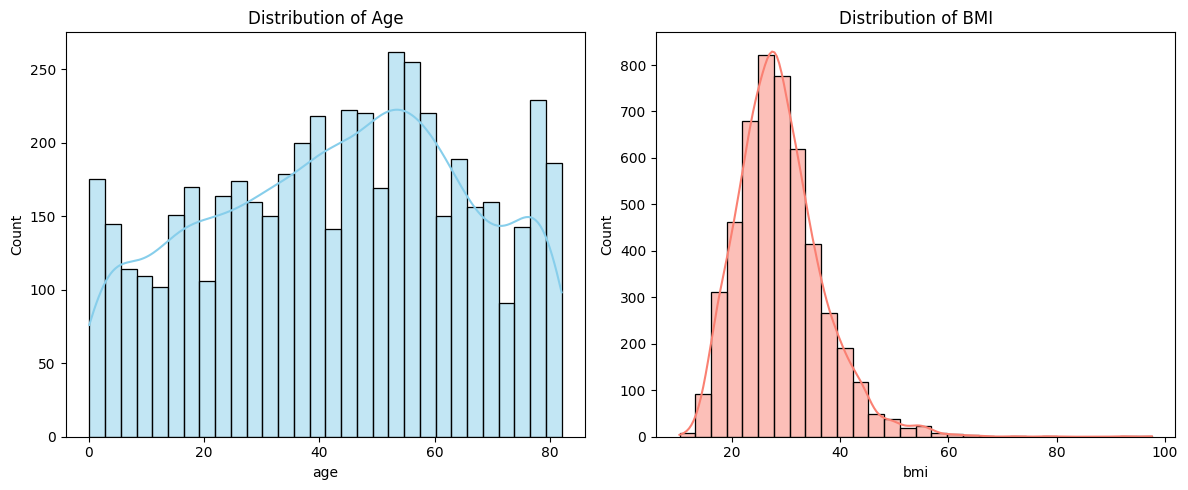

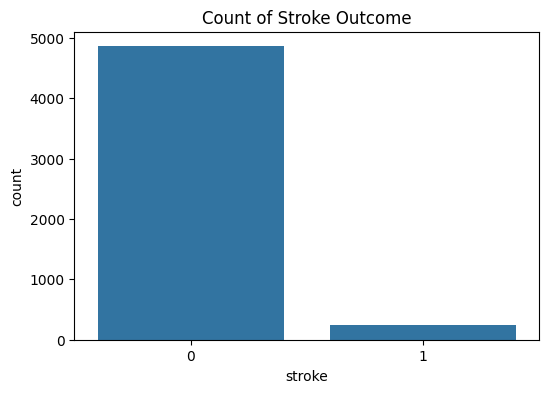

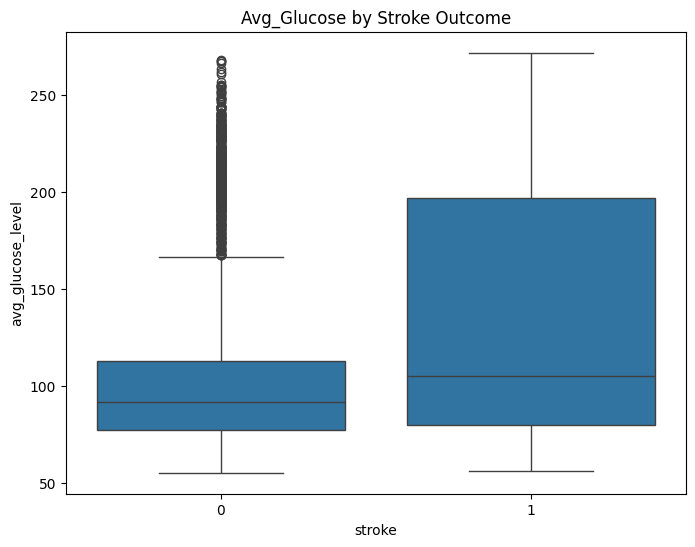

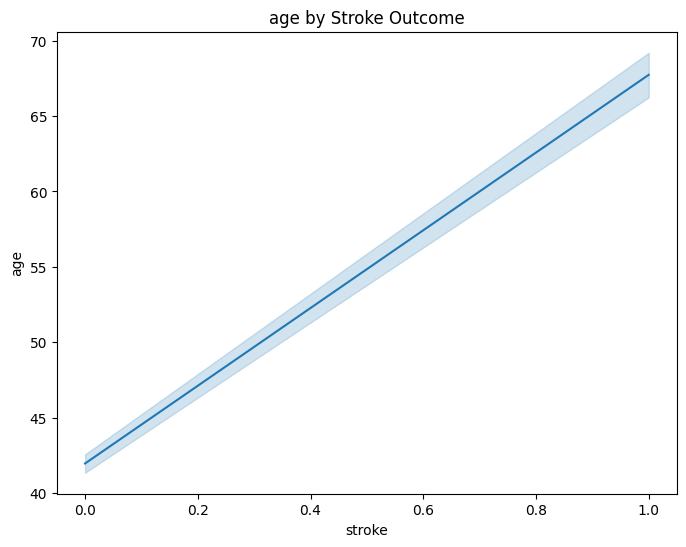

In [46]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data2=data2.select_dtypes(include=[np.number])
if numeric_data2.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data2.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data2['age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data2['bmi'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=data2)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=data2)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='stroke', y='age', data=data2)
plt.title('age by Stroke Outcome')
plt.show()

In [47]:
# change the Strig value to numeric
encoder=LabelEncoder()
data['gender']=encoder.fit_transform(data['gender'])
data['ever_married']=encoder.fit_transform(data['ever_married'])
data['work_type']=encoder.fit_transform(data['work_type'])
data['Residence_type']=encoder.fit_transform(data['Residence_type'])
data['avg_glucose_level']=encoder.fit_transform(data['avg_glucose_level'])
data['smoking_status']=encoder.fit_transform(data['smoking_status'])

**Feature Engnieering**

In [48]:
# divide the data i features and traget columns
X=data.drop('stroke',axis=1)
y=data['stroke']

**Model Seletion**

In [52]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [53]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

## RFC Model Training

Training RandomForestClassifier on dataset_2...
Metrics for RandomForestClassifier on dataset_2:
  accuracy: 0.9428
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  roc_auc: 0.7982


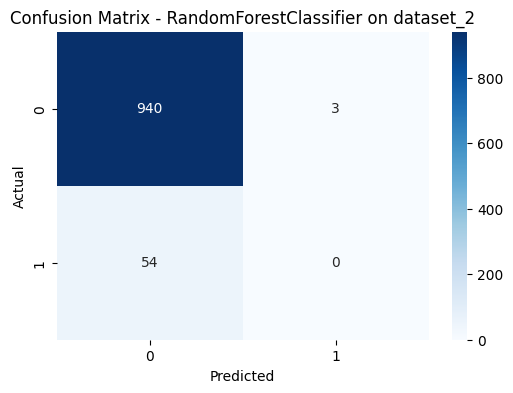

In [51]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=100,random_state=42)
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_2', 'RandomForestClassifier', results)

## SVC Model Training

Training SVM on dataset_2...
Metrics for SVM on dataset_2:
  accuracy: 0.9458
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  roc_auc: 0.6575


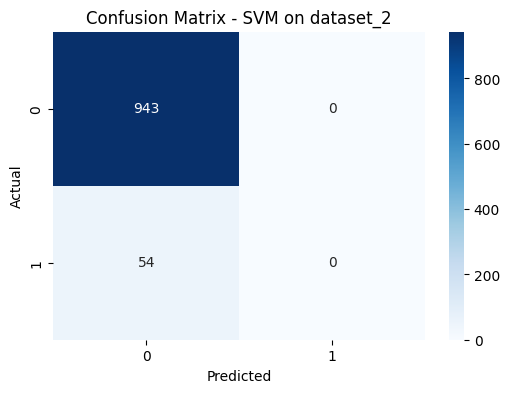

In [56]:
# train the SVM model
svm=SVC(kernel='rbf', probability=True)
train_and_evaluate_model(svm, X_train, X_test, y_train, y_test, 'dataset_2', 'SVM', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_2...
Metrics for LogisticRegression on dataset_2:
  accuracy: 0.7415
  precision: 0.5430
  recall: 0.7530
  f1: 0.6310
  roc_auc: 0.8333


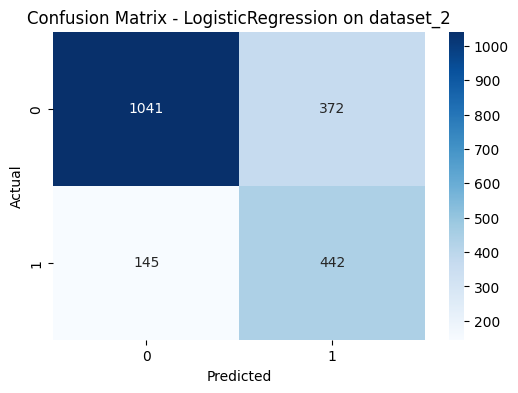

In [91]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_2', 'LogisticRegression', results)

# Dataset 3 Preprocessing and Training


In [58]:
# show the first five rows of data sets
data3.head()

,ID,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_Type,Avg_Glucose_Level,BMI,Smoking_Status,Stroke
0,30669,1,3.0,0,0,0,4,0,3984,18.0,3,0
1,30468,1,58.0,1,0,1,2,1,3268,39.2,1,0
2,16523,0,8.0,0,0,0,2,1,5544,17.6,3,0
3,56543,0,70.0,0,0,1,2,0,1378,35.9,0,0
4,46136,1,14.0,0,0,0,1,0,8677,19.1,3,0


In [59]:
# names of the columns
data3.columns

Index(['ID', 'Gender', 'Age', 'Hypertension', 'Heart_Disease', 'Ever_Married',
       'Work_Type', 'Residence_Type', 'Avg_Glucose_Level', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')

In [60]:
# check tha data types of data sets
data3.dtypes

,0
ID,int64
Gender,int64
Age,float64
Hypertension,int64
Heart_Disease,int64
Ever_Married,int64
Work_Type,int64
Residence_Type,int64
Avg_Glucose_Level,int64
BMI,float64


In [61]:
# check the info
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 43400 non-null  int64  
 1   Gender             43400 non-null  int64  
 2   Age                43400 non-null  float64
 3   Hypertension       43400 non-null  int64  
 4   Heart_Disease      43400 non-null  int64  
 5   Ever_Married       43400 non-null  int64  
 6   Work_Type          43400 non-null  int64  
 7   Residence_Type     43400 non-null  int64  
 8   Avg_Glucose_Level  43400 non-null  int64  
 9   BMI                41938 non-null  float64
 10  Smoking_Status     43400 non-null  int64  
 11  Stroke             43400 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 4.0 MB


In [62]:
# statistical summary of data set
data3.describe()

,ID,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_Type,Avg_Glucose_Level,BMI,Smoking_Status,Stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000
mean,36326.142350,0.408894,42.217894,0.093571,0.047512,0.643733,2.185438,0.501290,4332.331912,28.605038,1.591083,0.018041
std,21072.134879,0.492151,22.519649,0.291235,0.212733,0.478901,1.093158,0.500004,2966.640813,7.770020,1.095247,0.133103
min,1.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.100000,0.000000,0.000000
25%,18038.500000,0.000000,24.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2226.000000,23.200000,1.000000,0.000000
50%,36351.500000,0.000000,44.000000,0.000000,0.000000,1.000000,2.000000,1.000000,3630.000000,27.700000,1.000000,0.000000
75%,54514.250000,1.000000,60.000000,0.000000,0.000000,1.000000,3.000000,1.000000,5658.000000,32.900000,3.000000,0.000000
max,72943.000000,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,12542.000000,97.600000,3.000000,1.000000


In [63]:
data3.drop('ID',axis=1,inplace=True)

In [64]:
# statistical summary of data set
data3.describe()

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_Type,Avg_Glucose_Level,BMI,Smoking_Status,Stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000
mean,0.408894,42.217894,0.093571,0.047512,0.643733,2.185438,0.501290,4332.331912,28.605038,1.591083,0.018041
std,0.492151,22.519649,0.291235,0.212733,0.478901,1.093158,0.500004,2966.640813,7.770020,1.095247,0.133103
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.100000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2226.000000,23.200000,1.000000,0.000000
50%,0.000000,44.000000,0.000000,0.000000,1.000000,2.000000,1.000000,3630.000000,27.700000,1.000000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,1.000000,3.000000,1.000000,5658.000000,32.900000,3.000000,0.000000
max,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,12542.000000,97.600000,3.000000,1.000000


In [65]:
# check the how many people have smooking status
data3['Age'].value_counts()

,count
Age,
51.00,738
52.00,721
53.00,701
78.00,698
50.00,694
...,...
0.48,37
0.40,35
1.00,34


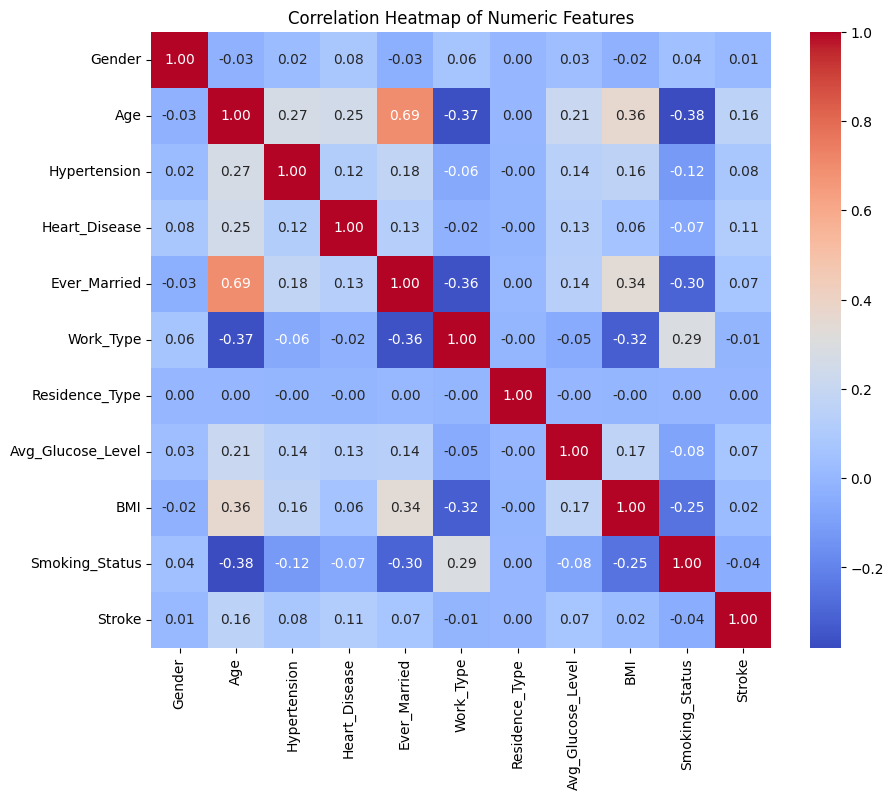

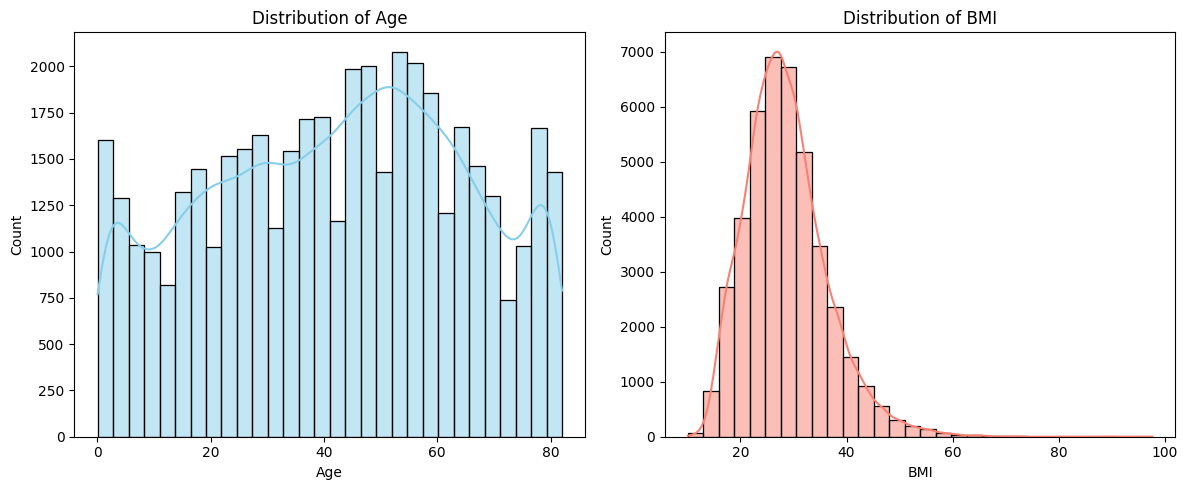

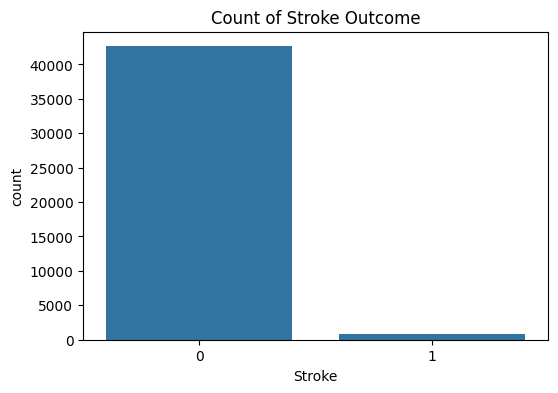

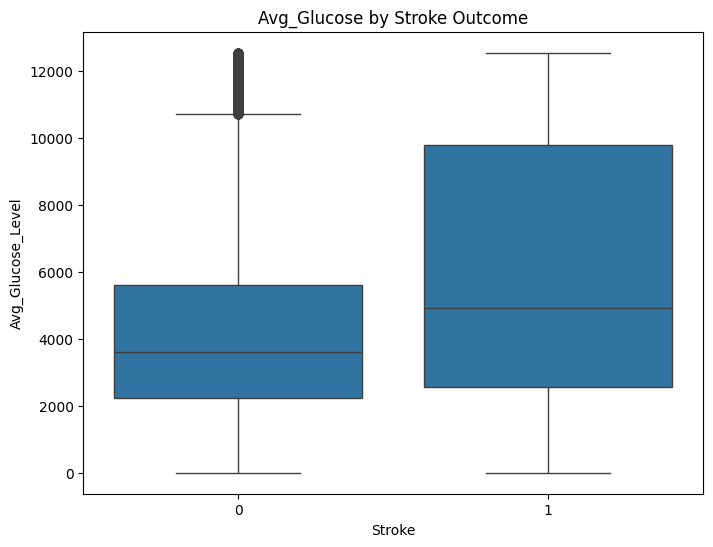

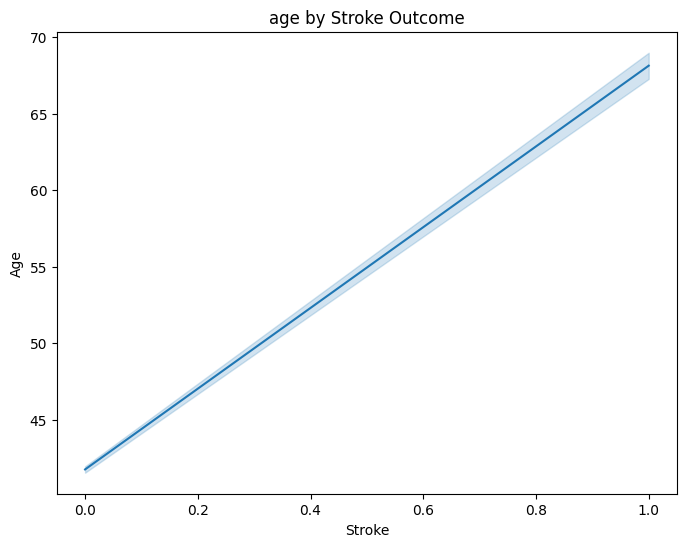

In [66]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data3=data3.select_dtypes(include=[np.number])
if numeric_data3.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data3.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data3['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data3['BMI'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='Stroke', data=data3)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stroke', y='Avg_Glucose_Level', data=data3)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='Stroke', y='Age', data=data3)
plt.title('age by Stroke Outcome')
plt.show()

In [67]:
# change the Strig value to numeric
encoder=LabelEncoder()
data3['Gender']=encoder.fit_transform(data3['Gender'])
data3['Ever_Married']=encoder.fit_transform(data3['Ever_Married'])
data3['Work_Type']=encoder.fit_transform(data3['Work_Type'])
data3['Residence_Type']=encoder.fit_transform(data3['Residence_Type'])
data3['Avg_Glucose_Level']=encoder.fit_transform(data3['Avg_Glucose_Level'])
data3['Smoking_Status']=encoder.fit_transform(data3['Smoking_Status'])

**Feature Engnieering**

In [68]:
# divide the data i features and traget columns
X=data.drop('stroke',axis=1)
y=data['stroke']

**Model Seletion**

In [69]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [70]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

## RFC Model Training

Training RandomForestClassifier on dataset_3...
Metrics for RandomForestClassifier on dataset_3:
  accuracy: 0.9428
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  roc_auc: 0.7982


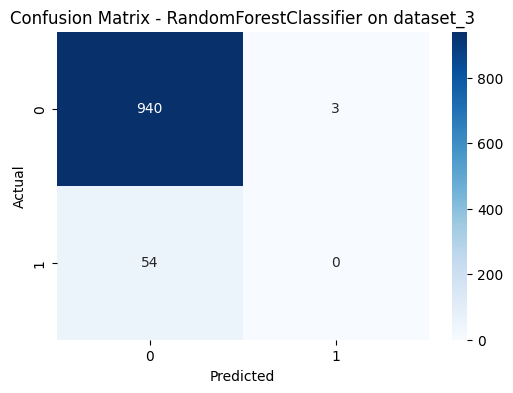

In [71]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=100,random_state=42)
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_3', 'RandomForestClassifier', results)

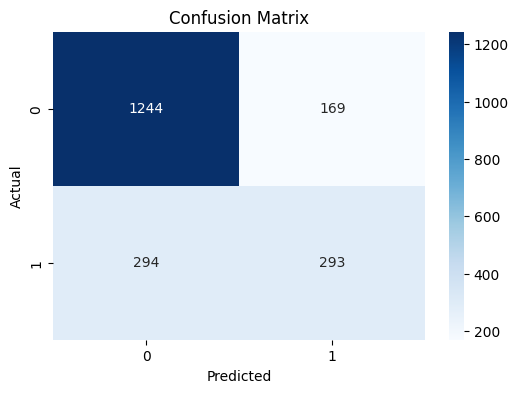

In [ ]:
# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVC Model Training

Training SVM on dataset_3...
Metrics for SVM on dataset_3:
  accuracy: 0.9458
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  roc_auc: 0.6574


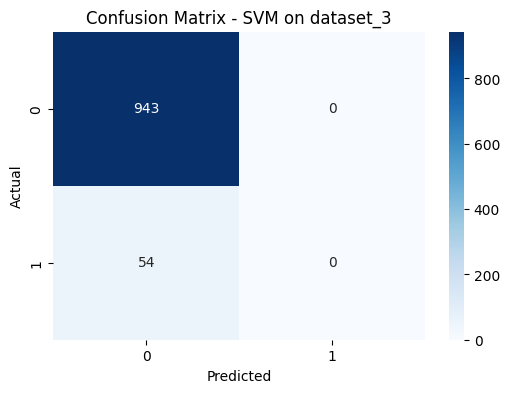

In [73]:
# train the SVM model
svm=SVC(kernel='rbf', probability=True)
train_and_evaluate_model(svm, X_train, X_test, y_train, y_test, 'dataset_3', 'SVM', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_3...
Metrics for LogisticRegression on dataset_3:
  accuracy: 0.7312
  precision: 0.1480
  recall: 0.8333
  f1: 0.2514
  roc_auc: 0.8498


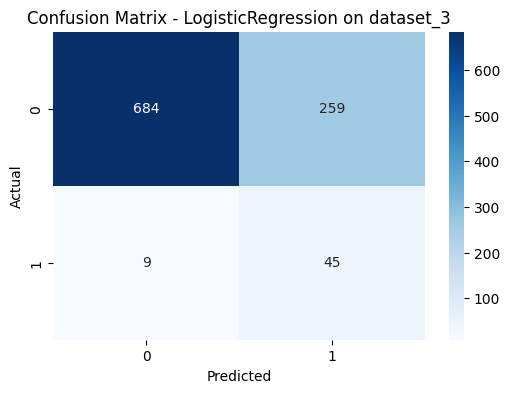

In [74]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_3', 'LogisticRegression', results)

# Dataset 4 Preprocessing and Training


In [75]:
# show the first five rows of data sets
data4.head()

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
0,66.788137,1,2,1,0,25.842521,96.428681,1,0,1
1,86.393609,0,2,1,1,32.531061,133.350068,0,2,1
2,76.158579,0,2,1,0,40.681244,111.489589,0,2,0
3,72.477870,0,1,0,1,33.003193,125.692465,0,1,0
4,59.881635,1,1,0,0,26.062443,123.218486,1,2,1


In [76]:
# names of the columns
data4.columns

Index(['Age', 'Gender', 'SES', 'Hypertension', 'Heart_Disease', 'BMI',
       'Avg_Glucose', 'Diabetes', 'Smoking_Status', 'Stroke'],
      dtype='object')

In [77]:
# check tha data types of data sets
data4.dtypes

,0
Age,float64
Gender,int64
SES,int64
Hypertension,int64
Heart_Disease,int64
BMI,float64
Avg_Glucose,float64
Diabetes,int64
Smoking_Status,int64
Stroke,int64


In [78]:
# check the info
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             10000 non-null  float64
 1   Gender          10000 non-null  int64  
 2   SES             10000 non-null  int64  
 3   Hypertension    10000 non-null  int64  
 4   Heart_Disease   10000 non-null  int64  
 5   BMI             10000 non-null  float64
 6   Avg_Glucose     10000 non-null  float64
 7   Diabetes        10000 non-null  int64  
 8   Smoking_Status  10000 non-null  int64  
 9   Stroke          10000 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 781.4 KB


In [79]:
# statistical summary of data set
data4.describe()

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,69.757847,0.496300,1.308200,0.605800,0.302800,28.042252,109.115918,0.196000,1.388900,0.297800
std,9.869468,0.500011,0.786177,0.488703,0.459492,4.901424,16.421142,0.396988,0.806301,0.457314
min,27.706561,0.000000,0.000000,0.000000,0.000000,15.037988,45.569135,0.000000,0.000000,0.000000
25%,63.128574,0.000000,1.000000,0.000000,0.000000,24.660786,98.188349,0.000000,1.000000,0.000000
50%,69.796042,0.000000,2.000000,1.000000,0.000000,28.066932,109.022208,0.000000,2.000000,0.000000
75%,76.402885,1.000000,2.000000,1.000000,1.000000,31.390170,120.341179,0.000000,2.000000,1.000000
max,99.417448,1.000000,2.000000,1.000000,1.000000,47.495955,176.180688,1.000000,2.000000,1.000000


In [80]:
# check the how many people have smooking status
data4['Age'].value_counts()

,count
Age,
83.321557,1
65.086238,1
72.598524,1
66.239181,1
73.408627,1
...,...
59.881635,1
72.477870,1
76.158579,1


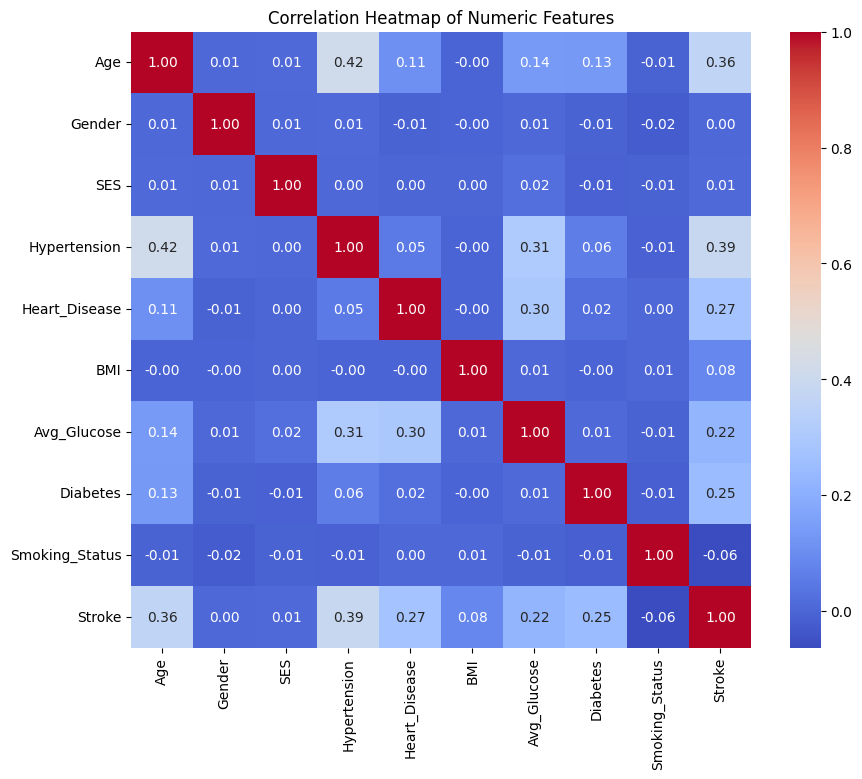

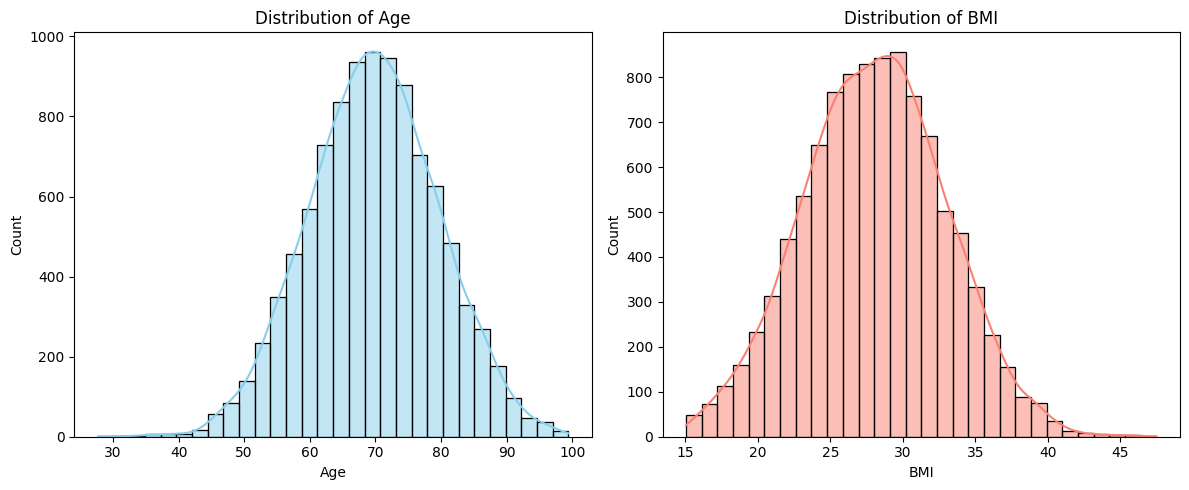

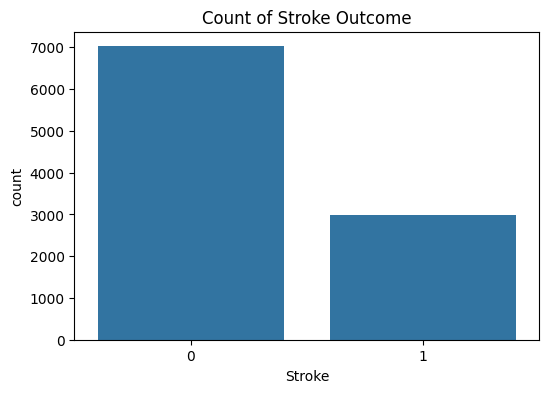

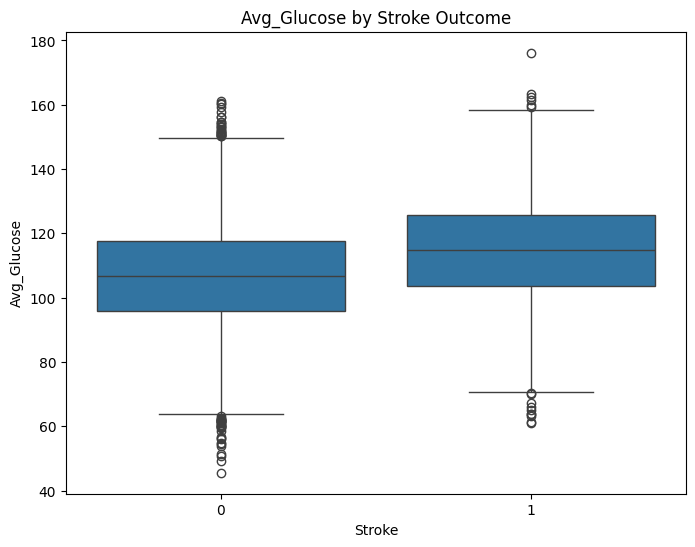

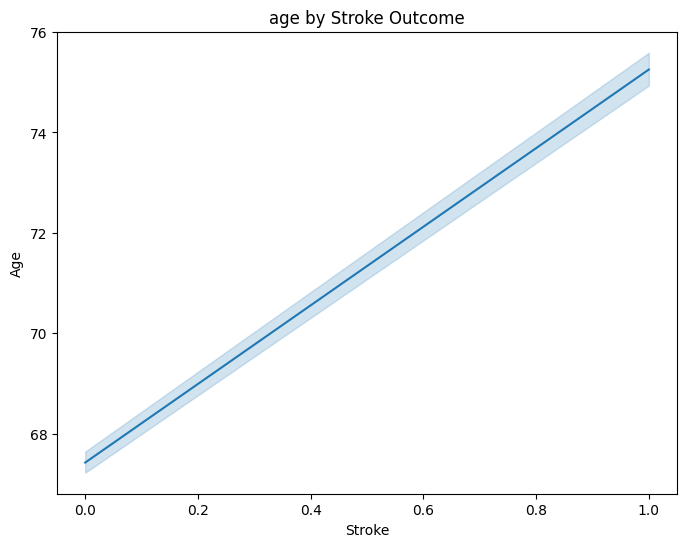

In [81]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data4=data4.select_dtypes(include=[np.number])
if numeric_data4.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data4.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data4['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data4['BMI'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='Stroke', data=data4)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stroke', y='Avg_Glucose', data=data4)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='Stroke', y='Age', data=data4)
plt.title('age by Stroke Outcome')
plt.show()

In [82]:
# change the Strig value to numeric
encoder=LabelEncoder()
data4['Gender']=encoder.fit_transform(data4['Gender'])
data4['SES']=encoder.fit_transform(data4['SES'])
data4['Smoking_Status']=encoder.fit_transform(data4['Smoking_Status'])

**Feature Engnieering**

In [83]:
# divide the data i features and traget columns
X=data4.drop('Stroke',axis=1)
y=data4['Stroke']

**Model Seletion**

In [84]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [85]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

## RFC Model Training

Training RandomForestClassifier on dataset_4...
Metrics for RandomForestClassifier on dataset_4:
  accuracy: 0.7750
  precision: 0.6539
  recall: 0.4957
  f1: 0.5640
  roc_auc: 0.8095


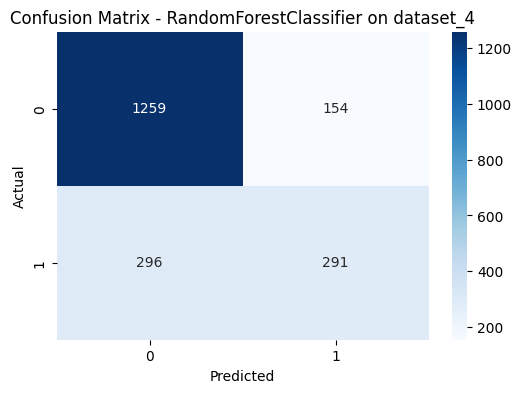

In [90]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=300,random_state=42, class_weight='balanced')
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_4', 'RandomForestClassifier', results)

## SVC Model Training

Training SVM on dataset_4...
Metrics for SVM on dataset_4:
  accuracy: 0.7855
  precision: 0.6674
  recall: 0.5366
  f1: 0.5949
  roc_auc: 0.7923


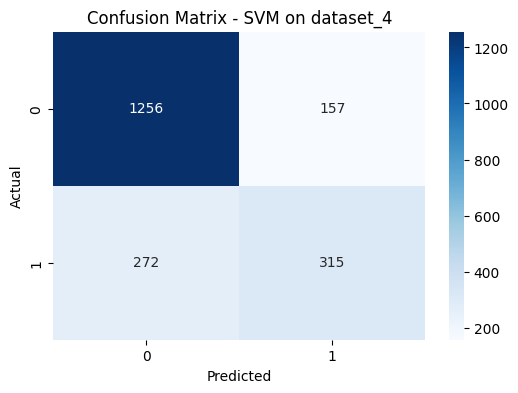

In [89]:
# train the SVM model
svm=SVC(kernel='rbf', probability=True)
train_and_evaluate_model(svm, X_train, X_test, y_train, y_test, 'dataset_4', 'SVM', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_4...
Metrics for LogisticRegression on dataset_4:
  accuracy: 0.7415
  precision: 0.5430
  recall: 0.7530
  f1: 0.6310
  roc_auc: 0.8333


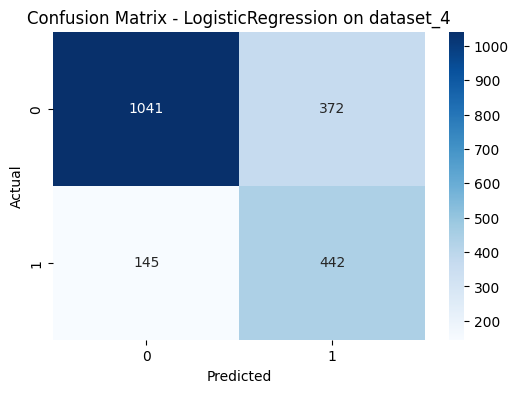

In [87]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_4', 'LogisticRegression', results)